# Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
import pickle
from scipy.stats import pearsonr
import pandas as pd
from src import utils
import seaborn as sns

## Independent models

In [2]:
df_list = []

for dataset in range(10):
    data = torch.load('data/dataset_{}.pkl'.format(dataset))
    for cell in range(20):
        z_data = data['z'][cell]
        w_data = data['w'][0]

        results = pickle.load(open('results/independent_models/dataset_{}/cell_{}/final/latents.pkl'.format(dataset, cell), 'rb'))
        z = results['z'][0]
        z = torch.nan_to_num(z, 0)
        z /= z.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
        w = results['w']
        w /= w.max(dim=0)[0].view(1, data['n_factors'])

        inds, _ = utils.optimal_assignment(z_data, z, 0)

        z = z[inds]
        w = w[:, inds]

        z_corr = pearsonr(z.flatten(), z_data.flatten())[0]
        w_corr = pearsonr(w.flatten(), w_data.flatten())[0]

        df_list.append(pd.DataFrame({
            'model' : 'independent',
            'dataset' : dataset,
            'cell' : cell,
            'w_corr' : w_corr,
            'z_corr' : z_corr,
            'n_cells' : 1,
        }, index=[0]))

independent_evaluation = pd.concat(df_list)

## Multicell models

In [3]:
df_list = []

for dataset in range(10):
    data = torch.load('data/dataset_{}.pkl'.format(dataset))
    z_data = data['z']
    w_data = data['w'][0]

    for n_cells in [2, 3, 4, 5, 10, 15, 20]:
        results = pickle.load(open('results/multicell_models/dataset_{}/{}_cells/final/latents.pkl'.format(dataset, n_cells), 'rb'))
        z = results['z']
        z = torch.nan_to_num(z, 0)
        z /= z.flatten(start_dim=2).max(dim=-1)[0].view(n_cells, data['n_factors'], 1, 1)
        z = torch.nan_to_num(z, 0)
        w = results['w']
        w /= w.max(dim=0)[0].view(1, data['n_factors'])
        w = torch.nan_to_num(w, 0)

        inds, _ = utils.optimal_assignment(z_data[:n_cells], z, 1)

        z = z[:, inds]
        w = w[:, inds]

        for cell in range(n_cells):
            z_corr = pearsonr(z[cell].flatten(), z_data[cell].flatten())[0]
            w_corr = pearsonr(w.flatten(), w_data.flatten())[0]

            df_list.append(pd.DataFrame({
                'model' : 'multicell',
                'dataset' : dataset,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
                'cell' : cell,
                'n_cells' : n_cells,
            }, index=[0]))

    multicell_evaluation = pd.concat(df_list)

## Plots

In [4]:
df_list = []

for n_cells in [2, 3, 4, 5, 10, 15, 20]:
    independent_evaluation_subset = independent_evaluation[independent_evaluation.cell<n_cells]
    independent_evaluation_subset = independent_evaluation_subset.groupby('dataset')[['w_corr', 'z_corr']].mean().reset_index()
    independent_evaluation_subset['n_cells'] = n_cells
    independent_evaluation_subset['model'] = 'independent'
    df_list.append(independent_evaluation_subset)

    multicell_evaluation_subset = multicell_evaluation[multicell_evaluation.n_cells==n_cells]
    multicell_evaluation_subset = multicell_evaluation_subset.groupby('dataset')[['w_corr', 'z_corr']].mean().reset_index()
    multicell_evaluation_subset['n_cells'] = n_cells
    multicell_evaluation_subset['model'] = 'multicell'
    df_list.append(multicell_evaluation_subset)

evaluation = pd.concat(df_list)

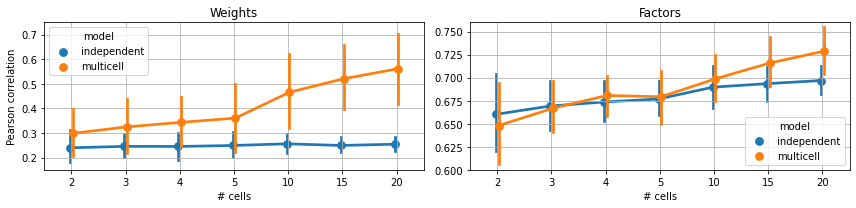

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

sns.pointplot(x='n_cells', y='w_corr', data=evaluation, hue='model', ax=axs[0], dodge=True)
axs[0].set_title('Weights')
axs[0].set_ylabel('Pearson correlation')
im = sns.pointplot(x='n_cells', y='z_corr', data=evaluation, hue='model', ax=axs[1], dodge=True)
axs[1].set_title('Factors')
axs[1].set_ylabel('')

for i, ax in enumerate(axs):
    ax.set_ylim([0.15, 0.60][i], [0.75, 0.76][i])
    ax.set_xlabel('# cells')
    ax.grid(axis='both')
plt.tight_layout()
plt.show()